In [ ]:
# re-building our training set

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt #for making figures
%matplotlib inline

In [2]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [ ]:
len(words)

In [3]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [ ]:
# build the dataset

block_size = 3 #context length : how many characters do we take to predict the next one? Given the previous 3 chars, what is the next one?
X, Y = [], []

for w in words:
    
    # print(w)
    context = [0] * block_size
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        # print(''.join(itos[i] for i in context) ,'---->', itos[ix])
        context = context[1:] + [ix] # crop and append. gets ride of the first value in context array, and adds the next character
X = torch.tensor(X)
Y = torch.tensor(Y)

In [ ]:
X #essentially all the context for all the words

In [ ]:
Y #all of the labels for all of the chars in all of the words

In [ ]:
# Now we willl write a neural network that should take in all the X's and then predict the Y's

In [4]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [5]:
C = torch.randn((27,2)) #essentially squeezing our 27 different characters into a 2 dimensional space. so each character has a 2D "embedding"

In [ ]:
C

In [9]:
# embed our inputs into C. i would watch this part of the video again
emb = C[Xtr]
emb.shape

torch.Size([182625, 3, 2])

In [10]:
W1 = torch.randn((6,100)) #weights. number of inputs it 3*2 bc we have 3 chars being embedded in 2 dimension. 100 neurons (up to us)
b1 = torch.randn(100) #biases. random-- up to us

# using this, we want to start our neural net using something along the lines of:
# emb @ W1 +b1, but emb is 32x3x2 and W1 is 36x6 so we cant muultiplt them

In [ ]:
torch.cat([emb[:,0,:], emb[:,1,:], emb[:,2,:]],1).shape
# this line takes our embedded inputs takes each of the 3 middle dimensions separately, and concatenates them along the first dimension so they add up to 6

In [ ]:
torch.cat(torch.unbind(emb,1),1).shape # same thing as above, but scaled with added context

In [ ]:
# emb.view(32,6) #same thing, but more efficient

In [ ]:
# we can do initialize all our neurons
h = torch.tanh(emb.view(-1,6) @ W1 + b1) #the -1 is pytorch inferring that we want the emb matrix to be (32,6)
# tanh will make all the values between -1 & 1
h

In [ ]:
h.shape

In [12]:
# create the final layer
W2 = torch.randn((100,27)) #new input is 100, and output is 27 bc we have 27 characters to choose from
b2 = torch.randn(27)

In [ ]:
logits = h @ W2 + b2 #outputs of the NN

In [ ]:
logits.shape

In [ ]:
counts = logits.exp() #fake counts

In [ ]:
prob = counts / counts.sum(1, keepdims=True)

In [ ]:
prob.shape

In [ ]:
Y

In [ ]:
# now we want to index into prob and find the probability assigned to the actual correct next character (which is in Y)

In [ ]:
torch.arange(32)

In [ ]:
# prob[torch.arange(32), Y] #iterates over Y at each index and puts them in order from first char to last

In [ ]:
# creat negative log likelihood loss function
# loss = -prob[torch.arange(32), Y].log().mean()
# loss

In [ ]:
loss = F.cross_entropy(logits, Y)
loss

In [ ]:
# organizing...

In [13]:
parameters = [C, W1,b1,W2,b2]

for p in parameters:
    p.requires_grad = True

In [14]:
# generate candidate learning rate
lre = torch.linspace(-3,0,1000) # 1000 values between -3 and 0
lrs = 10**lre #transforms them to numbers between -.001 and 1


In [15]:
lri = []
lossi = []
for i in range(10000):  # run this 1000 times
    
    #minibatch construction
    ix = torch.randint(0,Xtr.shape[0], (32,))

    # Forward pass
    emb = C[Xtr[ix]] # (32,3,2)
    h = torch.tanh(emb.view(-1,6) @ W1 + b1) # (32,100)
    logits = h @ W2 + b2 # (32,27)
    loss = F.cross_entropy(logits, Ytr[ix])
    #backward pass
    for p in parameters:
        p.grad = None # set gradients to 0
    loss.backward() #set gradients

    #update parameters based on gradient
    # lr = lrs[i]
    for p in parameters:
        p.data += -0.1 * p.grad
        
    # # track stats
    # lri.append(lre[i])
    # lossi.append(loss.item())

        

print(loss.item())

# low loss => good predictions!
# but here we are overfitting becuase we have so many parameters and only 32 data points from the first 5 words
# can go up and try again with the whole dataset

2.3296730518341064


In [ ]:
plt.plot(lri,lossi)

In [ ]:
# make batches so passes go quicker
torch.randint(0,X.shape[0], (32,))

In [16]:
# training split, dev/validation split, test split
#80%, 10%, 10%
# test split is used to validate performace of model AT THE END

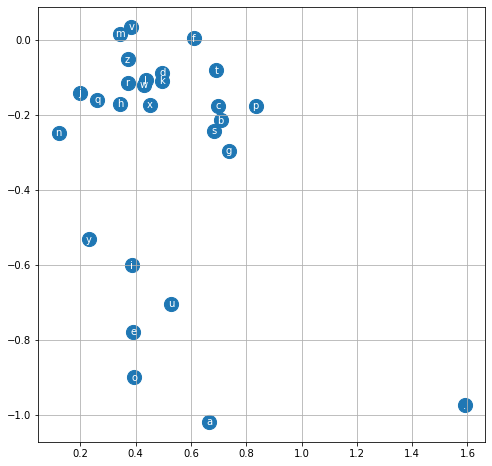

In [18]:
# visualize dimensions 0 and 1 of the embedding matrix C for all characters
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

#notice how the NN treat a,e,i,o,u,y as very similar
# cause they're values!